In [36]:
from __future__ import division

import glob
import os
import numpy as np
import pandas as pd
import sounddevice as sd
import pylab as pl
import random

from scipy.io import wavfile
import matplotlib.pyplot as plt
from python_speech_features import mfcc
from sklearn.cluster import MiniBatchKMeans

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
from adjustText import adjust_text
from collections import Counter
from scipy.io.wavfile import write
from sklearn.cluster import AgglomerativeClustering

from pyAudioAnalysis import audioBasicIO
from pyAudioAnalysis import ShortTermFeatures

import librosa
import pydub
from pydub import AudioSegment
import soundfile as sf
import tempfile
from pydub.utils import which
from scipy.io.wavfile import write
import scipy
import warnings 

AudioSegment.converter = which("ffmpeg")
%matplotlib inline

In [37]:
# Returns all clip indexes within a cluster
def get_clip_indexes(cluster_label, clusters):
    clips_i = []
    for i in range(len(clusters)):
        if clusters[i] == cluster_label:
            clips_i.append(i)
    return clips_i

# Plays a random clip in a given cluster
def play_random_clip_in_cluster(index, clusters, option='cluster'):
    assert(option == 'cluster' or option == 'clip')
    if option == 'clip':
        index = find_cluster(index, clusters) # Get cluster index
    
    clips = get_clip_indexes(index, clusters)
    clip_i = clips[random.randint(0, len(clips) - 1)]
    print('Playing clip index %d ' % clip_i)
    play_clip(clip_i)
        
# Returns the cluster label that a clip belongs to
def find_cluster(clip_index, clusters):
    return clusters[clip_index]

# Plays an audio clip given the clip index
def play_clip(clip_index):
    samples = shorter_clips[clip_index]
    sd.play(samples, samplerate)

# Flattens a given list
def list_flatten(l):
    flat_list = []
    for sublist in l:
        for item in sublist:
            flat_list.append(item)
    return flat_list

# Saves clip as a wav file
def save_clip(filename, wav_array):
#     assert('.' not in filename)
    write(filename + '.wav', samplerate, wav_array)
    
# Saves all clips to a directory
def save_clips_to_dir(shorter_clips, dirname):
    for i, clip in enumerate(shorter_clips):
        save_clip(dirname + '/%d' % i, clip) 
        
# def make_bird_species_list(bird_species_list, bird_name, index): 
#     "Define bird_species outside of function"
#     if bird_name not in bird_species_list[index]:
#         bird_species[index].append(bird_name)
# #     return bird_species_list
            
def convert_mp3_to_wav(mp3_path, sr=44100, mono=True, overwrite=False, dtype='float32'): 
    # Need to change sample rate to 44.1kHz if using audiomoths
    # since mono=True by default, unless you pass mono=False, 
    # this function will save the wav as mono
#     print("entering convert_mp3_to_wav")
    """
    Parts of code from 
    https://github.com/bill317996/Audio-to-midi/blob/master/cfp.py
    """
    warnings.warn("deprecated", DeprecationWarning)
    
    # in case there is an .MP3
    assert mp3_path.lower().endswith('.mp3'), 'filename indicates not mp3'
    wav_path_to_write = os.path.splitext(mp3_path)[0] + '.wav'
#     print(wav_path_to_write)
    
    if not overwrite and os.path.exists(wav_path_to_write):
        return
    
    mp3 = AudioSegment.from_file(mp3_path)
    
    _, temp_path = tempfile.mkstemp() 
    mp3.export(temp_path, format='wav')
#     print(temp_path)
    del mp3
    x, fs = sf.read(temp_path)
    os.remove(temp_path)
    
    if mono and len(x.shape)>1: 
        x = np.mean(x, axis = 1) 
    if sr:
        x = scipy.signal.resample_poly(x, sr, fs)
        fs = sr 
    x = x.astype(dtype)
#     print(fs)
    write(wav_path_to_write, fs, x)
    return x, fs

def read(f, normalized=False):
    """MP3 to numpy array"""
    a = pydub.AudioSegment.from_file(f)
    y = np.array(a.get_array_of_samples())
    if a.channels == 2:
        y = y.reshape((-1, 2))
    if normalized:
        return a.frame_rate, np.float32(y) / 2**15
    else:
        return a.frame_rate, y
    
def find_bird_species_from_file_name(filename): 
    preprocessed = ''.join([c for c in os.path.splitext(filename)[0] if not c.isnumeric()]) 
    parts = preprocessed.split('_')
#     print(type(parts))
#     print(parts)

    current_species = []
    species_set = set()

    for p in parts:
        print(p)
        if len(p) == 0: 
            continue
        elif p[0].isupper():
            if len(current_species) > 0: 
                species_set.add(tuple(current_species))
            current_species = [p]
        else: 
            current_species.append(p)
            

    species_set.add(tuple(current_species))
    return species_set

## Load Audio Data

In [38]:
dir_path = '/Volumes/Elements/Madre_de_Dios_Xeno_Canto_Birdcalls/'
# dir_path = '/Volumes/Elements/Test/'
samplerate = None
wav_data = []
wav_names = []
num_files = 0

for file in glob.glob(os.path.join(dir_path, '*.mp3')):
#     print(file)
#     convert_mp3_to_wav(file, overwrite=True)
    num_files = num_files+1
    try: 
        data, rate = convert_mp3_to_wav(file, overwrite=True)
#         data = data.astype(int)
        samplerate = rate
        if wav_data == []:
            wav_data = data
        else:
            wav_data = np.concatenate((wav_data, data))
        clip_len = len(data) / samplerate
        
        # Input only bird species
        bird_species = file.split(' - ')[2][:-4].replace(' ', '_')
        wav_names.append([bird_species, clip_len])
#         print(file)
        
        # TO DO: deal with deprecation warning, don't suppress
        warnings.filterwarnings("ignore", category=DeprecationWarning) 
    except Exception as e:
        print('(failed) ' + file)
        print('\t' + str(e))
        pass

In [39]:
print("shape of wav_data", wav_data.shape)
print("sample rate", samplerate)
print("type of wav_data", type(wav_data))
print('sample rate = %d' % samplerate)
length = wav_data.shape[0] / samplerate
print('length = %.1fs' % length)
# print(len(wav_names))

shape of wav_data (645859892,)
sample rate 44100
type of wav_data <class 'numpy.ndarray'>
sample rate = 44100
length = 14645.3s


## Split Audio Data

In [40]:
# Get n-minute clips
def split_into_minutes(wav_data, samplerate, n=1):
    length_in_seconds = len(wav_data) / samplerate
    length_in_minutes = length_in_seconds / 60
    length_in_minutes = int(length_in_minutes / n)

    cut_wav_data = wav_data[:-((len(wav_data)) % length_in_minutes)]
    shorter_clips = np.split(cut_wav_data, length_in_minutes)
    print('%d %d-minute clips' % (len(shorter_clips), n))
    return shorter_clips

# Get n-second clips
def split_into_n_seconds(wav_data, wav_names, samplerate, n=5):
    file_names = []
    
    length_in_seconds = len(wav_data) / samplerate
#     print("length in seconds",length_in_seconds)
    length_in_minutes = length_in_seconds / 60
    length_in_minutes = length_in_minutes
#     print(length_in_minutes)
    shorter_len = int(length_in_minutes / (1/(60/n)))
#     print("shorter length", shorter_len)
    
    n_real = length_in_seconds/shorter_len
#     print("n real", n_real)
    
    second_clips = None
    
    try:
        second_clips = np.split(wav_data, shorter_len)
    except:
        cut_wav_data = wav_data[:-((len(wav_data)) % shorter_len)]
        second_clips = np.split(cut_wav_data, shorter_len)

    # wav_name[0][0]="Versasilles birdopolus", wav_name[0][1]=12
    # wav_name[1][0]="Amazilia lactea",        wav_name[1][1]=9
    # wav_name[2][0]="Ramphastos vitellinus",  wav_name[2][1]=7
    # 'Versasilles_birdopolus_Split.wav', 'Versasilles_birdopolus2_Amazilia_lactea_Split.wav', 'Ramphastos_vitellinus7_Split.wav'

    ### NAMING FILES ###
    i = 0
    amount_left = 0
    first_case_count = 0 
    
    while i < len(wav_names):
#         print(wav_names[i][1], "wav_names")
#         print(i)
        # create new clip from just one bird
#         print(wav_names[i][1], "wav_names[i][1]")

        if wav_names[i][1] >= n_real and amount_left == 0:        
#             print("first test case")
#             print("i", i)
#             print("amount_left", amount_left)
#             print("first_case_count", first_case_count)
#             print()
#             file_names.append(wav_names[i][0] + "_Split_%d" % first_case_count)
            file_names.append(wav_names[i][0] + str(first_case_count))    
#             HERE: wav_names[i][1] -= n_real
            
            wav_names[i][1] -= n
        
            wav_names[i][1] -= wav_names[i][1]
            first_case_count+=1
        
        # create new clip and leave it unfinished
        elif 0 < int(wav_names[i][1]) < n_real and amount_left == 0:
                    
#             print("second test case")
#             print("i", i)
#             print("amount_left", amount_left)
#             print()
#             file_names.append(wav_names[i][0] + str(int(wav_names[i][1])) + "_")
            file_names.append(wav_names[i][0] + "_")
            
            amount_left = n_real - wav_names[i][1]
            
            wav_names[i][1] = 0
            i+=1
            
        # finish prev clip
        elif wav_names[i][1] >= amount_left and amount_left > 0:
#             print("third test case")
#             print("i", i)
#             print("amount_left", amount_left)
#             print()
#             file_names[-1] += wav_names[i][0] + "_Split"
            file_names[-1] += wav_names[i][0]
            wav_names[i][1] -= amount_left
            amount_left = 0
        
        # if length is 0
        elif int(wav_names[i][1]) == 0:
#             print("Hits zero case")
#             print("i", i)
#             print("amount_left", amount_left)
#             print()
            i+=1
            
        elif wav_names[i][1] < amount_left and amount_left > 0: 
#             print("contribute to previous clip and not ending clip")
#             print("i", i)
#             print("amount_left", amount_left)
#             print()

#             file_names[-1] += wav_names[i][0] + str(int(wav_names[i][1])) + "_"
            file_names[-1] += wav_names[i][0]

            amount_left = n_real - wav_names[i][1]
#             amount_left = n - wav_names[i][1]
        
            wav_names[i][1] = 0
            i+=1
    
#     file_names[-1] += "_Split.wav"
#     print(file_names)
    print(n_real)
    print('%d %d-second clips' % (len(second_clips), n_real))
    return second_clips, file_names

In [41]:
#shorter_clips = split_into_minutes(wav_data, samplerate, 1)
shorter_clips, file_names = split_into_n_seconds(wav_data, wav_names, samplerate, 5)
print(len(shorter_clips))
print(len(file_names))

5.0001191618106215
2929 5-second clips
2929
254


In [26]:
def find_bird_species_from_file_name(filename): 
    preprocessed = ''.join([c for c in os.path.splitext(filename)[0] if not c.isnumeric()]) 
    parts = preprocessed.split('_')

    current_species = []
    species_set = set()

    for p in parts:
#         print("p", p)
        if len(p) == 0: 
            continue
        elif p[0].isupper():
            if len(current_species) > 0: 
                species_set.add(tuple(current_species))
            current_species = [p]
        else: 
            current_species.append(p)

    species_set.add(tuple(current_species))
    return species_set

# Spectrograms

In [12]:
def plot_spectrogram(samplerate, shorter_clips, clip_index, separate_channels=False):
    left_channel = shorter_clips[clip_index][:, 0]
    right_channel = shorter_clips[clip_index][:, 1]
    
    plt.rcParams["figure.figsize"] = (100, 100)
    plt.rcParams.update({'font.size': 50})
    plt.xlabel('Time')
    plt.ylabel('Frequency')
    
    plt.subplot(211)
    if separate_channels:
        plt.title('Clip #%d (Left Channel)' % clip_index)
        plt.specgram(left_channel, Fs=samplerate)
        plt.subplot(212)
        plt.title('Clip #%d (Right Channel)' % clip_index)
        plt.specgram(right_channel, Fs=samplerate)
    else:
        plt.title('Clip #%d' % clip_index)
        both_channels = left_channel + right_channel
        plt.specgram(both_channels, Fs=samplerate)

    plt.show()
    
def plot_spectrogram_of_cluster(samplerate, shorter_clips, cluster_i, clusters, separate_channels=False):
    clip_indexes = get_clip_indexes(cluster_i, clusters)
    
    left_channel = shorter_clips[clip_indexes[0]][:, 0]
    right_channel = shorter_clips[clip_indexes[0]][:, 1]
    
    for i in range(1, len(clip_indexes)):
        left_channel = np.append(left_channel, shorter_clips[clip_indexes[i]][:, 0])
        right_channel = np.append(right_channel, shorter_clips[clip_indexes[i]][:, 1])
    
    plt.rcParams["figure.figsize"] = (100, 100)
    plt.rcParams.update({'font.size': 50})
    plt.xlabel('Time')
    plt.ylabel('Frequency')
    
    plt.subplot(211)
    if separate_channels:
        plt.title('Cluster #%d (Left Channel)' % cluster_i)
        plt.specgram(left_channel, Fs=samplerate)
        plt.subplot(212)
        plt.title('Cluster #%d (Right Channel)' % cluster_i)
        plt.specgram(right_channel, Fs=samplerate)
    else:
        plt.title('Cluster #%d' % cluster_i)
        both_channels = left_channel + right_channel
        plt.specgram(both_channels, Fs=samplerate)

    plt.show()

# Feature Extraction

In [8]:
# TODO: Add a way to select and evaluate features

def extract_features(shorter_clips, mfcc_only=False, mono=False):
    feat_clips = []

    print('Extracting features for each of the %d audio clips' % len(shorter_clips))
    for clip in shorter_clips:
        if mono == False:
            clip = clip[:, 0] + clip[:, 1] # Merging left and right channels

        mfcc_feat=None
        if mfcc_only:
            mfcc_feat = mfcc(clip, samplerate, winlen=0.023, nfft = 1024).flatten()

        else:
            mfcc_feat = ShortTermFeatures.feature_extraction(clip, samplerate, 0.050*samplerate, 0.025*samplerate)
            print('')
            print(mfcc_feat[1])

        # Append the features
        if mfcc_only:
            feat_clips.append(mfcc_feat)
        else:
            feat_clips.append(list_flatten(mfcc_feat[0]))

    print('done')
    return feat_clips
    
# Set mfcc_only to True to shorten runtime
mfcc_clips = extract_features(shorter_clips, mfcc_only=True, mono=True)
#all_feat_clips = extract_features(shorter_clips)


Extracting features for each of the 2929 audio clips
done


In [37]:
print(len(mfcc_clips))

1464


# Clustering

In [9]:
dist = 1 - cosine_similarity(mfcc_clips)
mds = PCA(n_components=2, random_state=1)
pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

X = pos

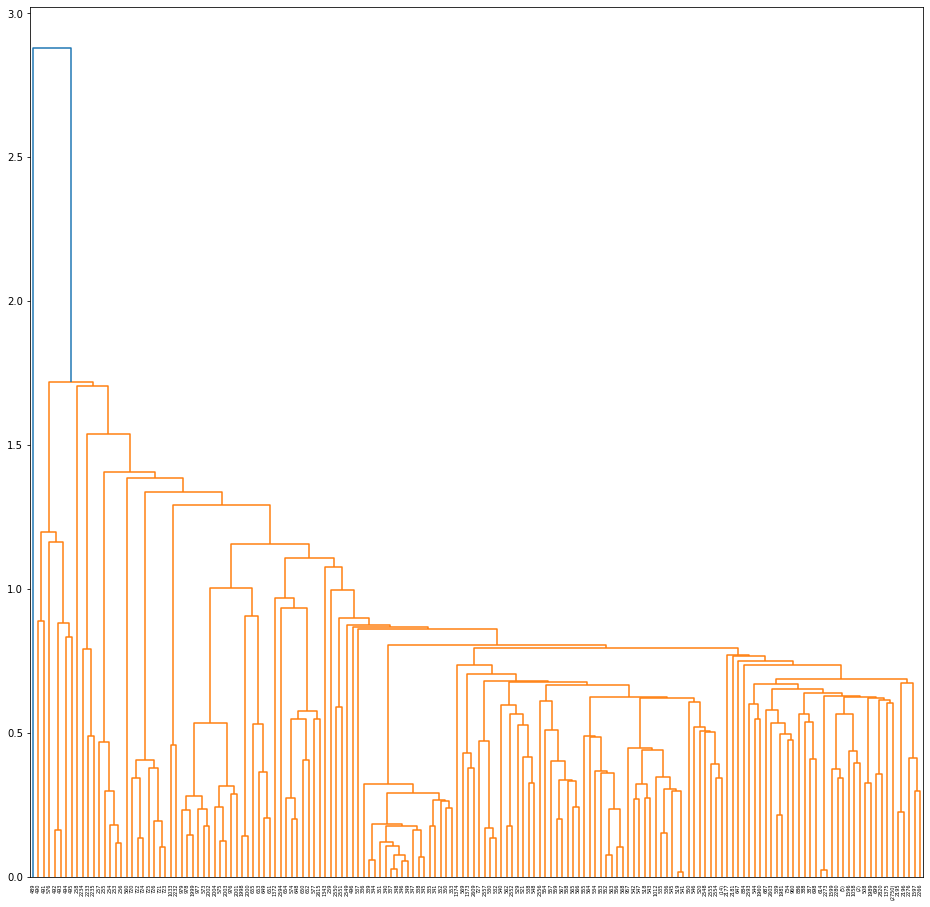

In [10]:
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt

linked = linkage(X, 'single')

labelList = range(len(X))

plt.figure(figsize=(16, 16))
dendro = dendrogram(linked,
#             p=7,
            orientation='top',
            #labels=labelList,
            truncate_mode='level',
            distance_sort='descending',
            show_leaf_counts=True)
plt.show()

In [11]:
def cluster_plot(pos, title='', without_labels=False, width=20, height=20, savepath=''):
    plt.rc('font', size=15)
    
    xs, ys = pos[:, 0], pos[:, 1]
    
    labels = range(len(shorter_clips))

    # Data frame with TSNE data, the cluster numbers and titles
    cluster_df = pd.DataFrame(dict(x=xs, y=ys, clusters=clusters, labels=labels)) 

    fig, ax = plt.subplots(figsize=(width, height))
    ax.margins(0.05)
    ax.set_title(title)

    groups = cluster_df.groupby('clusters')
    for name, group in groups:
        ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, mec='none', label=name)
        ax.set_aspect('auto')
        ax.tick_params(axis= 'x', which='both', bottom='off', top='off', labelbottom='off')
        ax.tick_params(axis= 'y', which='both', left='off', top='off', labelleft='off')

    ax.legend(numpoints=1)
    ax.legend(bbox_to_anchor=(1.1, 1.05))

    #Add labels
    if not without_labels:
        texts = []
        for i in range(len(cluster_df)):
            texts.append(ax.text(cluster_df.loc[i, 'x'], cluster_df.loc[i, 'y'], cluster_df.loc[i,'labels'], size=10)) 

        #adjust_text(texts, arrowprops=dict(arrowstyle='->', color='red'))
    
    if savepath != '':
        plt.savefig(savepath, dpi=200, bbox_inches="tight")

    plt.show()

In [12]:
# Choose number of clusters: 
n_clusters = 134
# Chose 134 from the number of bird species in the XenoCanto data

# Fit clustering model
clusters = AgglomerativeClustering(n_clusters=n_clusters, affinity='euclidean', linkage='ward').fit_predict(mfcc_clips)

In [22]:
# savepath = '/Volumes/Elements/dendrogram'
plt.savefig(savepath, dpi=200, bbox_inches="tight")

PermissionError: [Errno 13] Permission denied: '/Volumes/Elements/dendrogram.png'

<Figure size 432x288 with 0 Axes>

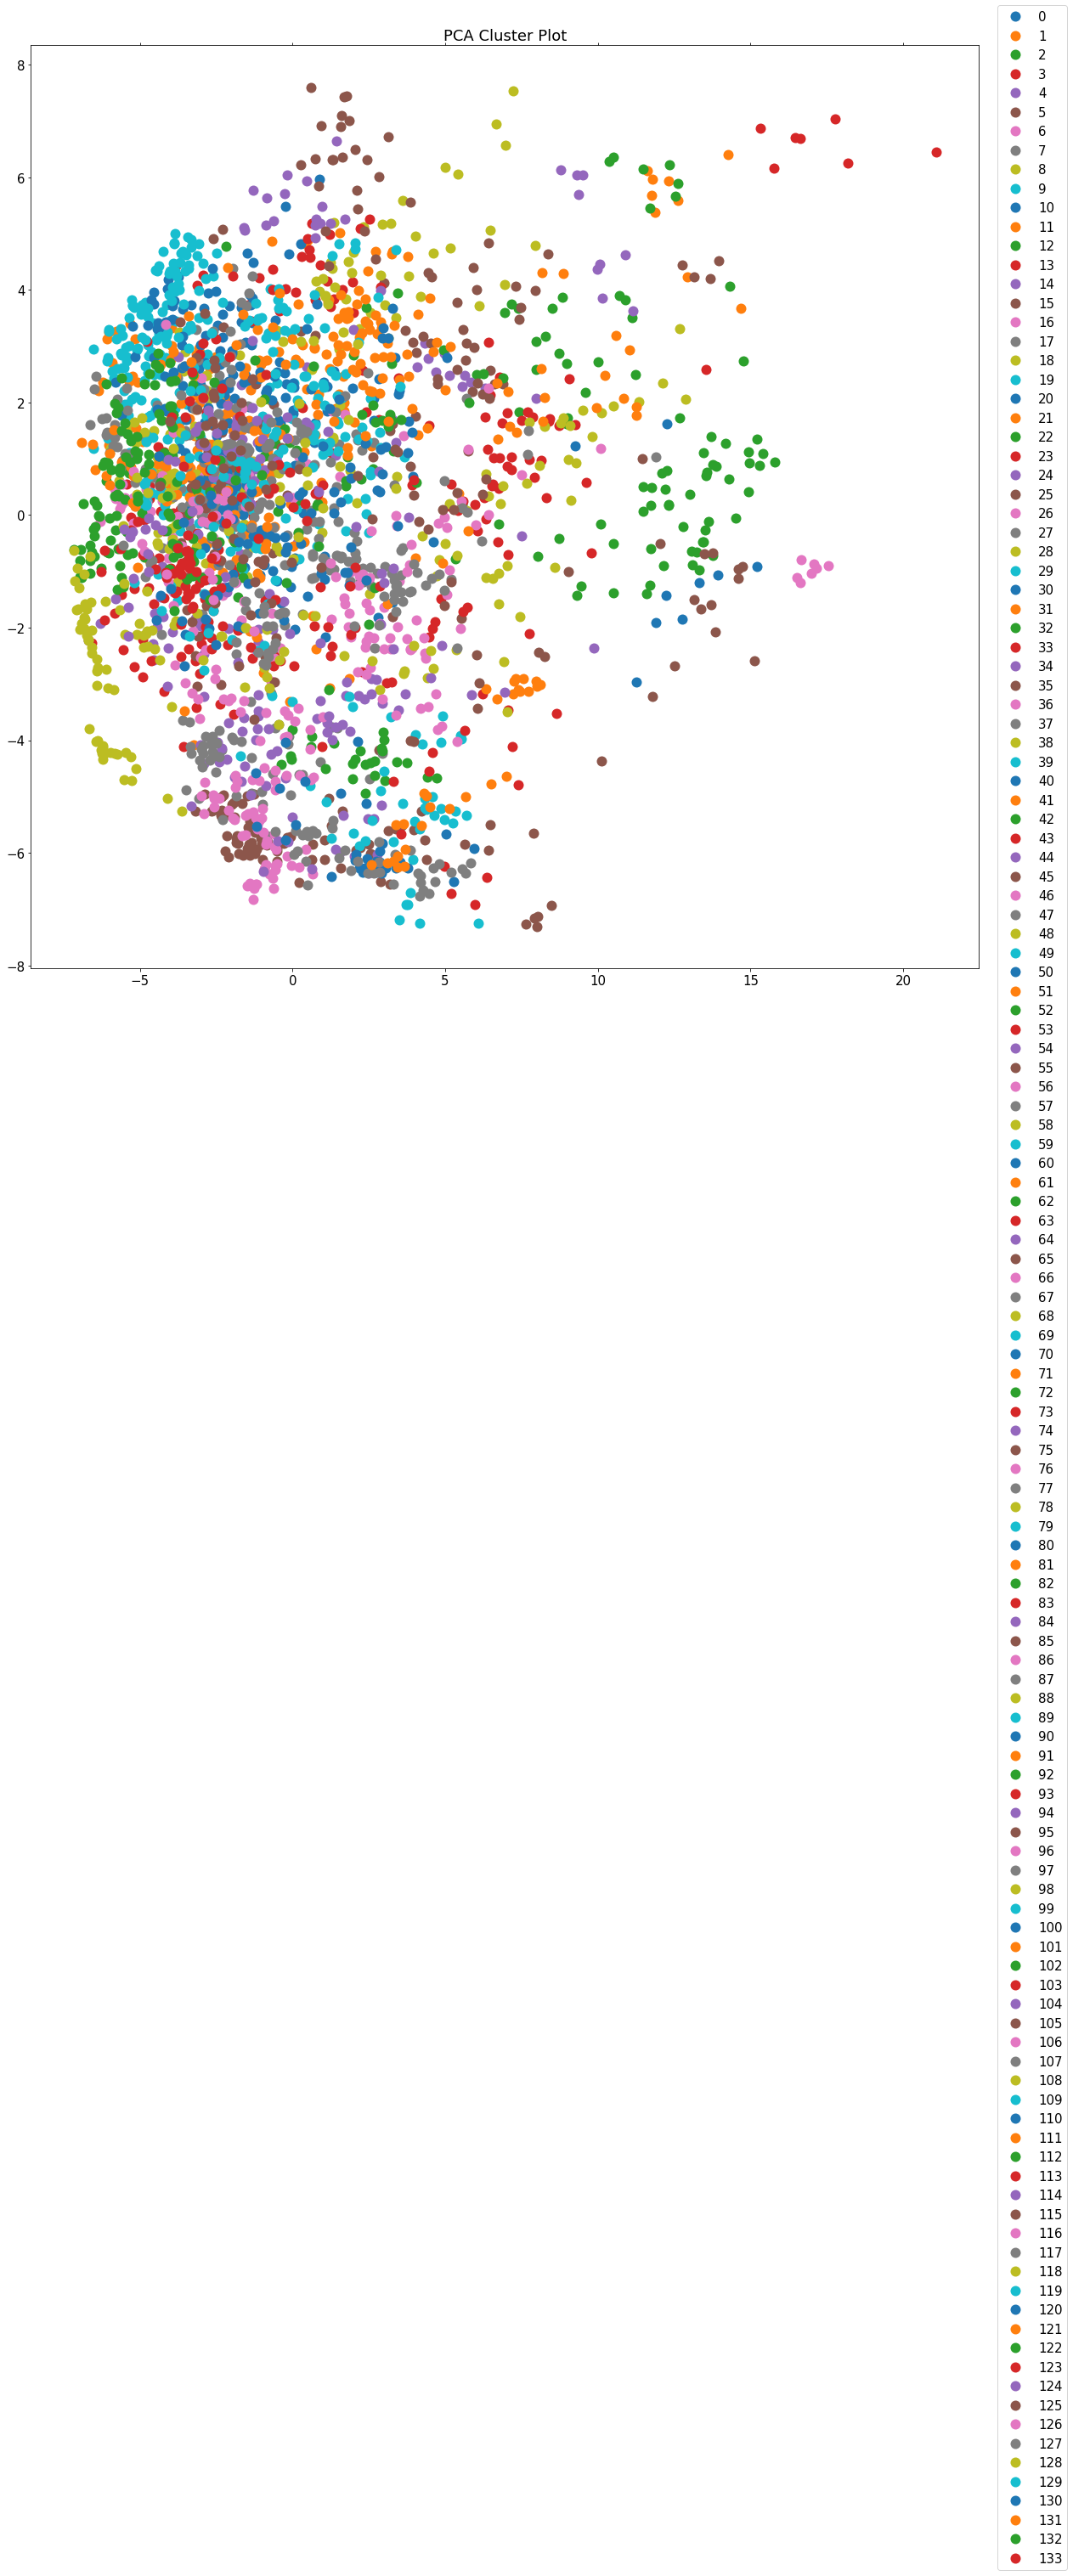

In [13]:
# Project the data onto 2D graph - 10 clusters
dist = 1 - cosine_similarity(mfcc_clips)
mds = PCA(n_components=2, random_state=1)
pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

# /Volumes/Elements/Madre_de_Dios_Xeno_Canto_Birdcalls/

cluster_plot(pos, 'PCA Cluster Plot', without_labels=True, savepath='/Volumes/Elements/Madre_de_Dios_Xeno_Canto_Birdcalls/Clusters_XenoCanto/pca.png')

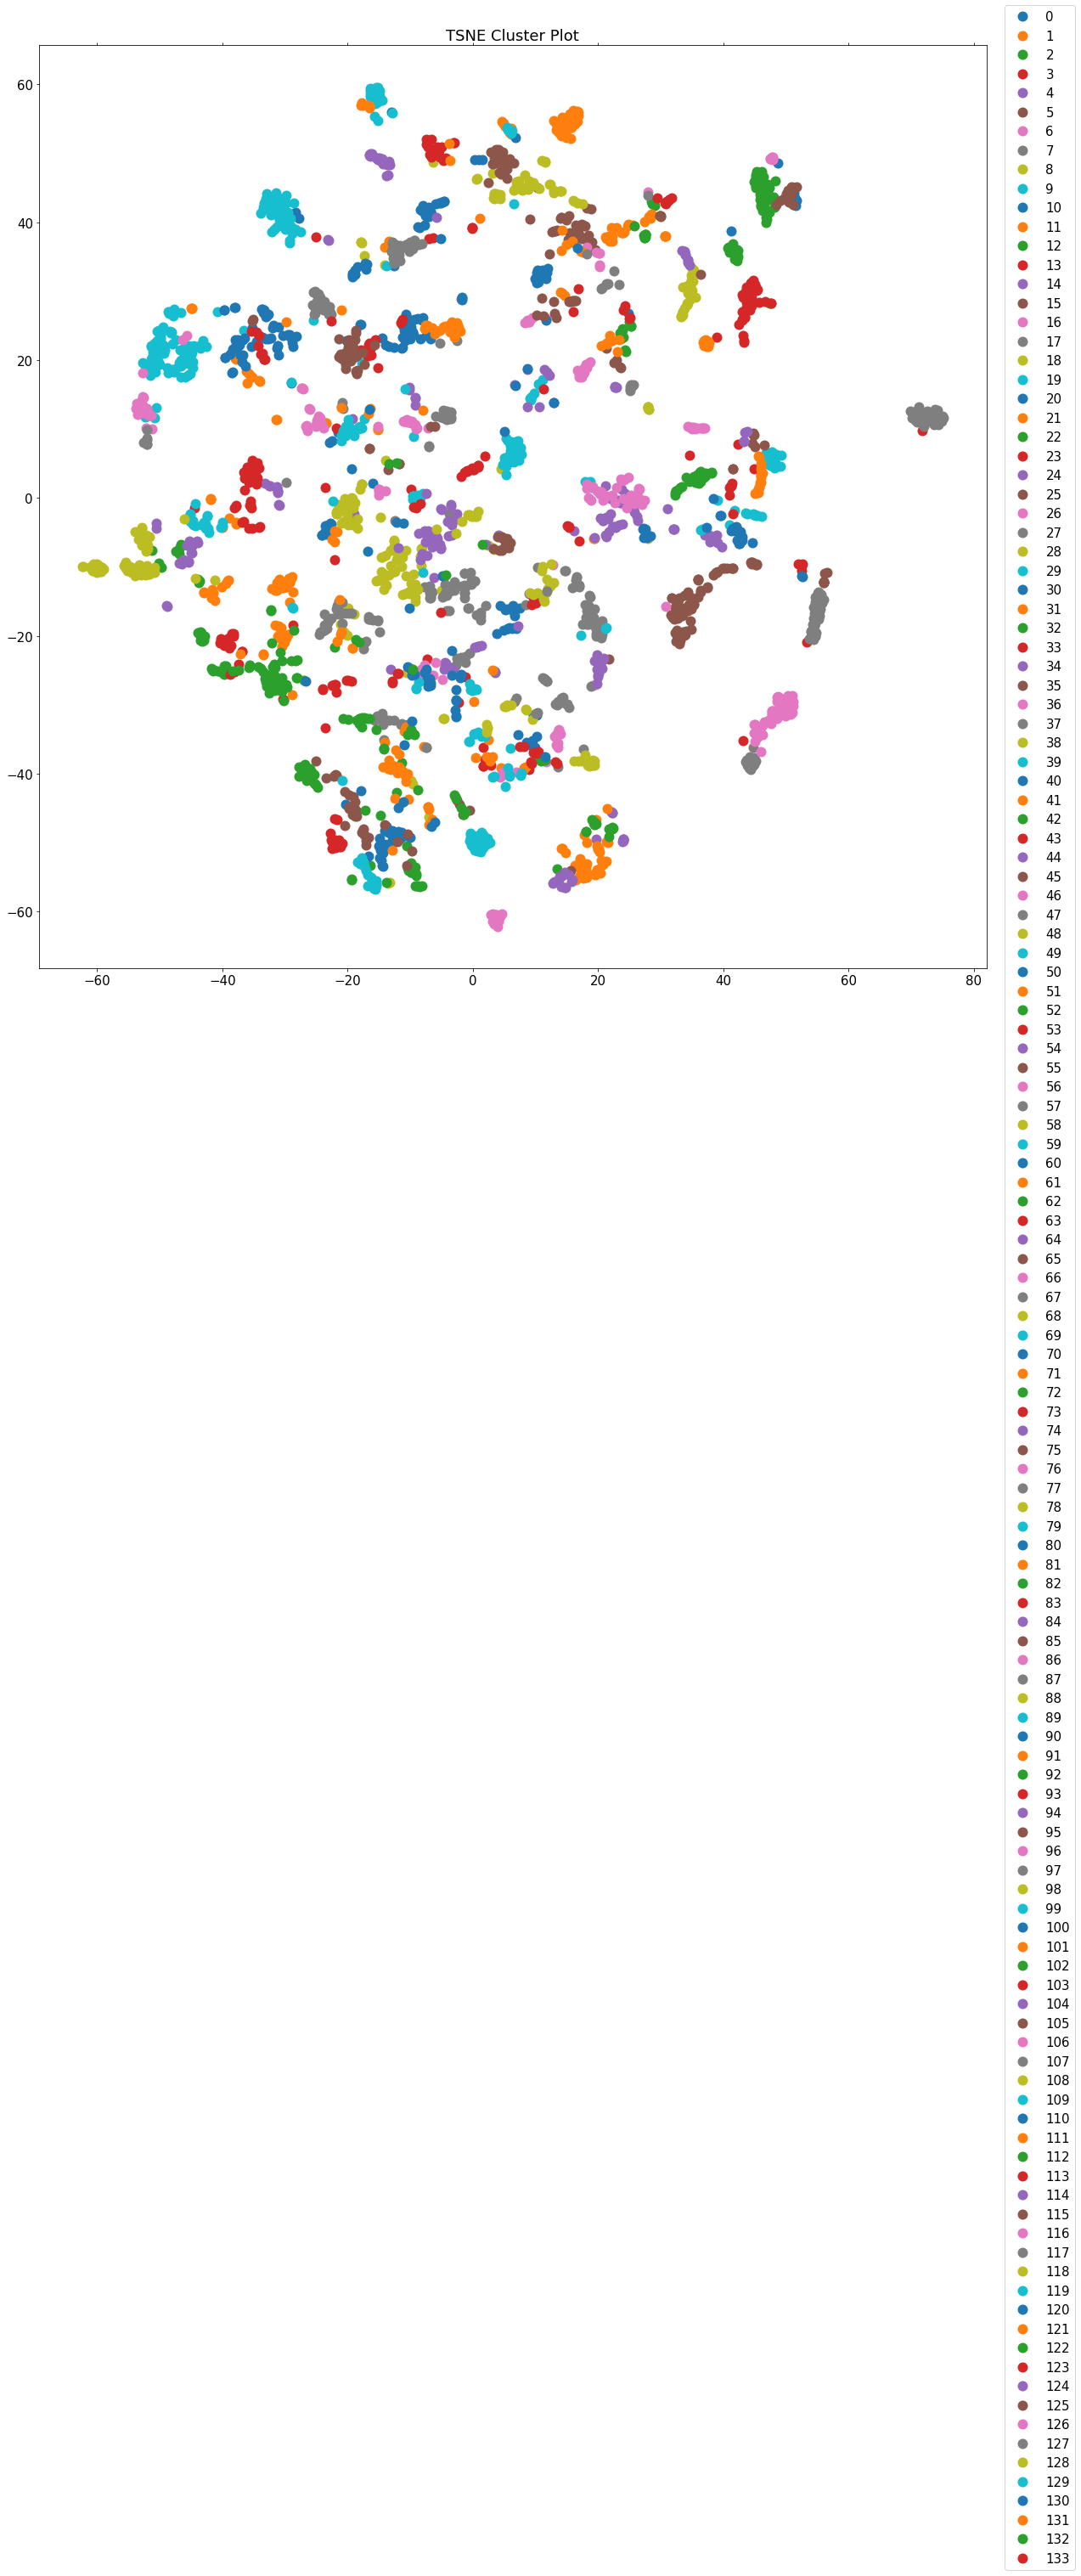

In [14]:
# Project the data onto 2D graph - 10 clusters
dist = 1 - cosine_similarity(mfcc_clips)
mds = TSNE(n_components=2, random_state=1)
pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

cluster_plot(pos, 'TSNE Cluster Plot', without_labels=True, savepath='/Volumes/Elements/Madre_de_Dios_Xeno_Canto_Birdcalls/Clusters_XenoCanto/tsne.png')

# Cluster Interpretation

In [16]:
# Prints: (Cluster number, count of clips in cluster)
Counter(clusters).most_common()

[(9, 89),
 (5, 67),
 (8, 64),
 (1, 59),
 (10, 59),
 (92, 56),
 (99, 53),
 (17, 49),
 (78, 48),
 (13, 46),
 (51, 44),
 (22, 42),
 (44, 41),
 (67, 40),
 (21, 40),
 (20, 40),
 (18, 38),
 (29, 37),
 (107, 36),
 (91, 36),
 (37, 35),
 (32, 34),
 (15, 34),
 (36, 33),
 (27, 33),
 (125, 33),
 (60, 33),
 (103, 33),
 (55, 32),
 (33, 31),
 (87, 30),
 (50, 30),
 (126, 30),
 (47, 29),
 (24, 29),
 (7, 29),
 (28, 28),
 (41, 28),
 (79, 28),
 (16, 28),
 (54, 28),
 (52, 27),
 (43, 27),
 (59, 26),
 (42, 26),
 (88, 26),
 (71, 25),
 (115, 25),
 (23, 24),
 (77, 24),
 (73, 24),
 (102, 24),
 (49, 23),
 (34, 22),
 (109, 22),
 (0, 21),
 (119, 21),
 (39, 20),
 (100, 20),
 (118, 19),
 (97, 19),
 (40, 19),
 (106, 18),
 (46, 18),
 (3, 18),
 (61, 18),
 (19, 18),
 (90, 18),
 (76, 18),
 (121, 17),
 (86, 17),
 (74, 17),
 (127, 16),
 (26, 16),
 (2, 16),
 (69, 16),
 (6, 16),
 (123, 16),
 (25, 15),
 (82, 15),
 (108, 15),
 (12, 15),
 (58, 14),
 (38, 14),
 (124, 14),
 (94, 13),
 (45, 13),
 (120, 13),
 (89, 13),
 (4, 12),
 (3

In [28]:
play_random_clip_in_cluster(6, clusters) # Play random clip in a cluster

Playing clip index 433 


In [ ]:
sd.stop() # Stop playing

In [ ]:
# Can assign a label to each cluster here
#cluster_names = ['quiet', 'loud', 'quiet', 'rain', 'birds', 'crickets', 'birds', 'quiet', 'quiet', 'loud']

In [30]:
play_clip(36) 

## Save clusters of audio files

In [17]:
dirname = '/Volumes/Elements/Madre_de_Dios_Xeno_Canto_Birdcalls5/Clusters_XenoCanto5/'
# dirname = '/Volumes/Elements/Test/Clusters/'

for i in range(len(np.unique(clusters))):
    os.mkdir(dirname + 'cluster_%d' % i)
    for j in get_clip_indexes(i, clusters):
        print("i",i)
        print('j', j)
        print("file_names[j]", file_names[j])
        print("shorter_clips[j]", len(shorter_clips[j]))
        print()
        
#         save_clip(dirname + 'cluster_%d/%s' % (i, j), file_names[j])
        save_clip(dirname + 'cluster_%d/%s' % (i, file_names[j]), shorter_clips[j])
#         save_clip(dirname + 'cluster_%d/%s' % i, file_names[j]), shorter_clips[j])
#         save_clip(dirname + 'cluster_%d/%s' % (i, j), file_names[j]))

FileExistsError: [Errno 17] File exists: '/Volumes/Elements/Madre_de_Dios_Xeno_Canto_Birdcalls5/Clusters_XenoCanto5/cluster_0'

In [36]:
print(len(np.unique(clusters)))
print(np.unique(clusters))
print(get_clip_indexes(i, clusters))
print(len(clusters))
print(len(file_names))

134
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133]
[1452, 1453, 1454, 1455, 1456, 1457, 1458, 1459, 1460, 1461, 1462, 1463]
1464
1462


In [410]:
# loop through all the cluster folders 
from os import listdir
from os.path import isfile, join

dirname = '/Volumes/Elements/Madre_de_Dios_Xeno_Canto_Birdcalls/Clusters_XenoCanto/'
# dirname = '/Volumes/Elements/Test/Clusters/'
directory_list = os.listdir(dirname)
# print(directory_list)

final_bird_list = []
num_bird_species = []

for d in directory_list: 
    path = dirname + d
    file_list = os.listdir(path)
    
    cluster_set = set()
    for f in file_list: 
#         print(f)
        cluster_set = cluster_set | find_bird_species_from_file_name(f)
#         print(f)
    
    num_bird_species.append(len(cluster_set))
    final_bird_list.append(num_bird_species)
        
# print(final_bird_list)
# print(cluster_set)
print(num_bird_species)

[3, 7, 5, 3, 5, 10, 2, 2, 3, 2, 2, 3, 6, 9, 3, 6, 3, 7, 6, 7, 5, 6, 3, 5, 4, 4, 2, 6, 1, 4, 3, 6, 9, 2, 3, 5, 2, 3, 6, 7, 8, 3, 4, 1, 3, 4, 3, 3, 13, 5, 3, 2, 4, 3, 9, 2, 6, 5, 2, 2, 4, 1, 1, 11, 5, 2, 3, 10, 4, 2, 1, 2, 6, 2, 5, 1, 5, 2, 5, 1, 10, 2, 3, 5, 2, 2, 1, 2, 1, 7, 1]


91
4.1098901098901095


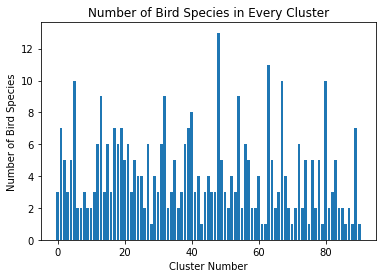

In [425]:
### PLOTTING ### 

print(len(num_bird_species))
cluster_num = range(0,len(num_bird_species))

x = cluster_num 
y = num_bird_species

# Add title, axes
plt.bar(x,y)
plt.title('Number of Bird Species in Every Cluster')
plt.xlabel('Cluster Number')
plt.ylabel('Number of Bird Species')

average_num_birds = sum(num_bird_species)/len(num_bird_species)
print(average_num_birds)

In [ ]:
# Plot spectrogram of all clips in a cluster appended together
plot_spectrogram_of_cluster(samplerate, shorter_clips, 7, clusters, separate_channels=False)

# Visualization

In [ ]:
num_clips = len(shorter_clips)
num_minutes = num_clips / 6
num_hours = num_minutes / 60

def clip_i_to_bin_i(clip_i):
    return int(clip_i / (num_clips/num_minutes))

def time_hist_for_cluster(cluster_i, clusters):
    hist_data = []
    for index in get_clip_indexes(cluster_i, clusters):
        index = clip_i_to_bin_i(index)
        hist_data.append(index)

    plt.ylim(0, (num_clips/num_minutes))
    plt.title('Cluster: %d (%s)' % (cluster_i, cluster_names[cluster_i]))
    plt.hist(hist_data, bins=int(num_minutes), range=[0, num_minutes])
    plt.show()
    
def colors(n):
    ret = []
    r = int(random.random() * 256)
    g = int(random.random() * 256)
    b = int(random.random() * 256)
    step = 256 / n
    for i in range(n):
        r += step
        g += step
        b += step
        r = int(r) % 256
        g = int(g) % 256
        b = int(b) % 256
        ret.append((r,g,b)) 
    return ret

def get_clusters_by_cluster_names(clusters, cluster_names):
    uniq_names = np.unique(cluster_names)
    print(uniq_names)
    new_clusters = [-1] * len(clusters)
    for uniq_name_i, uniq_name in enumerate(uniq_names):
        for name_i, name in enumerate(cluster_names):
            if name == uniq_name:
                # Assign name_i to each index in the cluster that has the same index
                for index in range(len(clusters)):
                    if clusters[index] == name_i:
                        new_clusters[index] = uniq_name_i
    return new_clusters

In [ ]:
named_clusters = get_clusters_by_cluster_names(clusters, cluster_names)
Counter(named_clusters).most_common() 
cluster_names_to_plot = np.unique(cluster_names)

# Colors for visualization
jet = pl.get_cmap('jet', len(cluster_names_to_plot))
cluster_colors = {}
for i, name in enumerate(cluster_names_to_plot):
    cluster_colors[name] = jet(i)

Note: These are not real labels for the clusters, this is just a demonstration of the code. The histogram visualization will be replaced with better visualizations for cluster/time data such as Rose Plots.

In [ ]:
def plot_all_histograms(clusters, cluster_names):
    plt.figure(figsize=(15,8))

    for cluster_i in range(len(cluster_names)):
        hist_data = []
        for index in get_clip_indexes(cluster_i, clusters):
            index = clip_i_to_bin_i(index)
            hist_data.append(index)

        cluster_name = cluster_names[cluster_i]
        c = cluster_colors[cluster_name]
        plt.hist(hist_data, bins=int(num_minutes), range=[0, num_minutes], alpha=0.5, color=c, label=cluster_name)

        plt.ylabel('Number of 10-second audio clips')
        plt.xlabel('Time in Minutes')
        plt.legend(bbox_to_anchor=(1.2, 1.05))
        plt.show()
    
clusters_to_plot = named_clusters
cluster_names_to_plot = np.unique(cluster_names)
plot_all_histograms(named_clusters, np.unique(cluster_names))

### (Optional) testing convert_mp3_to_wav function with one file
This is an extra step that I made to quickly check and troubleshoot the convert_mp3_to_wav function

In [148]:
dir_path = '/Volumes/Elements/Madre_de_Dios_Xeno_Canto_Birdcalls/'
file_path = dir_path + 'XC431125 - Rufous Twistwing - Cnipodectes superrufus.mp3'
# file_path = dir_path + 'XC91323 - White-eyed Parakeet - Psittacara leucophthalmus.mp3'

x, fs = convert_mp3_to_wav(file_path, overwrite=True)

In [1]:
# Graphs to sanity check output of load_audio with online mp3 to wav converter 

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(x)

print(x.shape)

# This file is from a random mp3 to wav convert I found here
# https://online-audio-converter.com/ and then downloaded on Desktop
check_dir_path = '/Users/yoo-jin/Desktop/XC431125 - Rufous Twistwing - Cnipodectes superrufus.wav'
x_test, fs_test = sf.read(check_dir_path)

x_test = np.mean(x_test, axis = 1) 
print(x_test.shape)

ax2.plot(x_test)


NameError: name 'plt' is not defined

### Optional: For K-means clustsering 
The function, find_optimal_clusters is used to find the optimal number of clusters for K-means clustering. Take a look at this link for more information: https://hlab.stanford.edu/brian/number_of_clusters_.html.

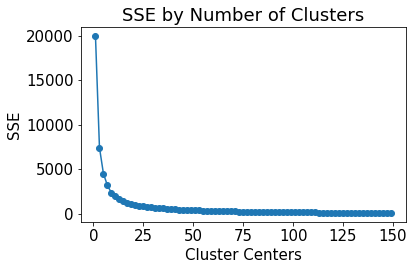

In [34]:
## TODO: plot.ly

def find_optimal_clusters(data, min_k, max_k): 
    iters= range(min_k, max_k+1, 2)
    
    sse = [] 
    for k in iters: 
        sse.append(MiniBatchKMeans(n_clusters=k, init_size=1024, batch_size=2048, random_state=20).fit(data).inertia_)
    
#     import pandas as pd
#     sse_pct_diff = pd.Series(sse)
#     sse_pct_diff.pct_change()
#     print(sse_pct_diff)
    
    f, ax = plt.subplots(1,1)
    ax.plot(iters, sse, marker = 'o')
    ax.set_xlabel('Cluster Centers')
#     ax.set_xticks(iters)
#     f.autofmt_xdate()
#     ax.set_xtickslabels(iters)
    ax.set_ylabel('SSE')
    ax.set_title('SSE by Number of Clusters')
    
#     ax[0].plot(iters, sse, marker = 'o')
#     ax[0].set_xlabel('Cluster Centers')
# #     ax.set_xticks(iters)
# #     f.autofmt_xdate()
# #     ax.set_xtickslabels(iters)
#     ax[0].set_ylabel('SSE')
#     ax[0].set_title('SSE by Number of Clusters')
    
#     ax[1].plot(iters, sse_pct_diff, marker = 'o')
#     ax[1].set_xlabel('Cluster Centers')
# #     ax.set_xticks(iters)
# #     f.autofmt_xdate()
# #     ax.set_xtickslabels(iters)
#     ax[1].set_ylabel('Percentage Change of SSE')
#     ax[1].set_title('Percentage Change of SSE by Number of Clusters')
    
    plt.tight_layout()

        
# Change the range here: 
find_optimal_clusters(X, 1, 150)

### Optional: list all bird species included in the file

In [112]:
dir_path = '/Volumes/Elements/Test/'
list_of_species = []

for f in glob.glob(os.path.join(dir_path, '*.mp3')): 
    bird_name = os.path.splitext(f)[0].split(" - ", 1)[1].strip()
    if list_of_species == []: 
        list_of_species = [bird_name]
    elif bird_name in list_of_species: 
        pass 
    else: 
        list_of_species.append(bird_name)

print(list_of_species)
# print(len(list_of_species))

['Blue-crowned Trogon - Trogon curucui', 'White-bellied Tody-Tyrant - Hemitriccus griseipectus', 'Sapphire-spangled Emerald - Amazilia lactea']
